In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white',font_scale = 1)
import numpy as np
from collections import defaultdict

# Dataset

- Roland Garros '17 Twitter dataset
- crawled stream of '@mention' events between Twitter users
- can be considered as timestamped directed edges between users

In [ ]:
data = pd.read_csv(
    "../data/rg17_preprocessed/edges.csv",
    sep='|',
    names=['time','source','target']
)

# Filtering the organizer account

The most frequent target node is the event organizer's account!

In [ ]:
data['target'].value_counts().head()

In [ ]:
most_pop = data['target'].value_counts().index[0]
data = data[data['target'] != most_pop].copy()

In [ ]:
plt.figure(figsize=(8,6))
interval = 60*60*24 #1 day since timeline is denominated in seconds
plt.plot(data['time'].groupby((data['time'] - data['time'].min()) // interval).count(),'o-');
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(range(20))
plt.xlabel('time (days)')
plt.ylabel('number of events')
sns.despine()

# Online link prediction task

- Based on the predictive sequential, "prequential" method
- For each instance in the stream
    - node specific, or a general link prediction (toplist) is generated and immediately evaluated
    - model is updated then with the new instance
- We simulate this by iterating on the records of the online data in time respecting order
- In this tutorial we generate source specific predictions

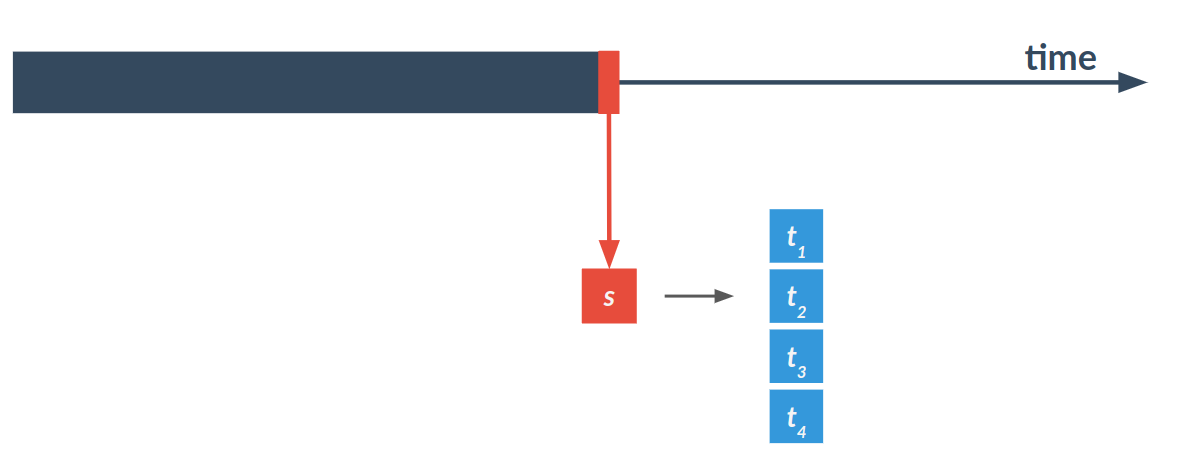

# Alpenglow

- Recommender system prototyping tool with prequential evaluation
- Various online and batch training scenarios can be simulated
- [github.com/rpalovics/Alpenglow](https://github.com/rpalovics/Alpenglow)

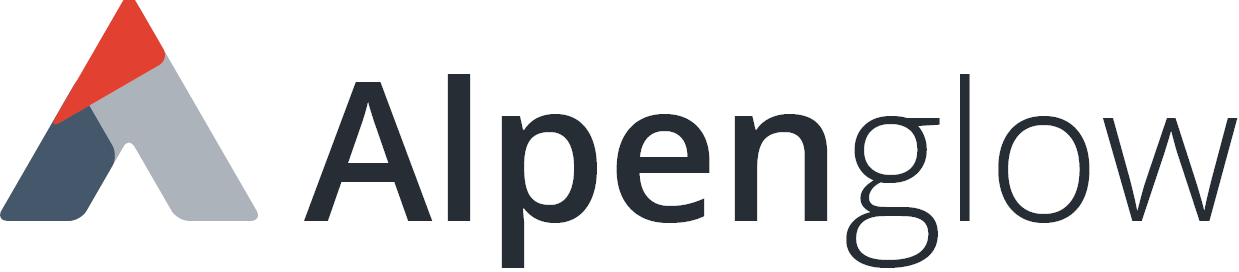

# Why a recommender framework?

- RecSys specific, collaborative filtering data is represented as bipartite graph
- Directed graphs are often modeled as bipartite graphs

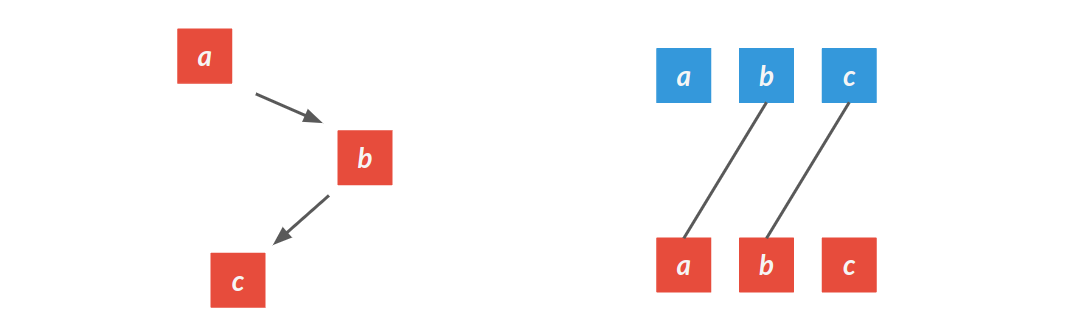

In [ ]:
from alpenglow.experiments import FactorExperiment
from alpenglow.evaluation import DcgScore
from alpenglow.experiments import PopularityExperiment
from alpenglow import SelfUpdatingModel, OnlineExperiment

# Degree based prediction

- record the in-degree of each target node
- at each stream event predict nodes with highest in-degrees 

In [ ]:
pop_experiment = PopularityExperiment(
    top_k=20,
    seed=254938879,
    network_mode=True,
)
pop_rankings = pop_experiment.run(data, verbose=True)

## Evaluation

- Each stream event specific prediction is evaluated separately

$$
\textrm{DCG} = \frac{1}{\log_2(\textrm{rank(t)}+1)}
$$

- DCG scores are then averaged over time

In [ ]:
pop_rankings['dcg'] = DcgScore(pop_rankings)
print('average dcg:', pop_rankings['dcg'].mean())

In [ ]:
plt.figure(figsize=(8,6))
pop_averages = pop_rankings['dcg'].groupby((pop_rankings['time']-pop_rankings['time'].min())//interval).mean()
plt.plot(pop_averages,'o-',label='in-degree',)
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(range(20))
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('DCG score')
sns.despine()

# Shallow node embeddings in Alpenglow
- simple shallow embedding method
- source and target specific embeddings are defined
- predictive score of a link between nodes s and t is the dot product of the corresponding embeddings

In [ ]:
factor_model_experiment = FactorExperiment(
    top_k=20, # we evaluate on toplists of size 20
    seed=254938879,
    dimension=100, # embedding dimension
    learning_rate=0.2, # if the data changes fast, we need a high lr
    negative_rate=150, # amount of negative samples generated
    network_mode=True, # switches Alpenglow to handle directed grahps
)
rankings = factor_model_experiment.run(data, verbose=True)

In [ ]:
plt.figure(figsize=(8,6))
rankings['dcg'] = DcgScore(rankings)
averages = rankings['dcg'].groupby((rankings['time']-rankings['time'].min())//interval).mean()
plt.plot(averages,'o-',label='node embedding')
plt.plot(pop_averages,'o-',label='in-degree')
plt.legend()
plt.xticks(range(20))
plt.xlabel('time (days)')
plt.ylabel('DCG score')
plt.xlim(0,)
plt.ylim(0,)
sns.despine()

# Filtering for duplicates

- Considerin the first appearence of each link is a relevant yet different problem

In [ ]:
data_filtered = data.drop_duplicates(['source', 'target']).copy()

In [ ]:
# re-running experiments...
factor_model_experiment = FactorExperiment(
    top_k=20,
    seed=254938879,
    dimension=100,
    learning_rate=0.3,
    negative_rate=150,
    network_mode=True,
)
rankings = factor_model_experiment.run(
    data_filtered,
    verbose=True,
    exclude_known=True # this parameter controls whether we rank seen edges
)
pop_experiment = PopularityExperiment(
    top_k=20,
    seed=254938879,
    network_mode=True,
)
pop_rankings = pop_experiment.run(
    data_filtered,
    verbose=True,
    exclude_known=True
)
rankings['dcg'] = DcgScore(rankings)
pop_rankings['dcg'] = DcgScore(pop_rankings)

In [ ]:
plt.figure(figsize=(8,6))
pop_averages = pop_rankings['dcg'].groupby((pop_rankings['time']-pop_rankings['time'].min())//interval).mean()
averages = rankings['dcg'].groupby((rankings['time']-rankings['time'].min())//interval).mean()
plt.plot(pop_averages, 'o-',label='in-degree')
plt.plot(averages, 'o-',label='node embedding')
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(range(20))
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('DCG score')
sns.despine()

# Parameter optimization

In [ ]:
res = []
learning_rates = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
for lr in learning_rates:
    factor_model_experiment = FactorExperiment(
        top_k=20,
        seed=254938879,
        dimension=100,
        learning_rate=lr,
        negative_rate=150,
        network_mode=True,
    )
    fac_rankings = factor_model_experiment.run(
        data_filtered, verbose=True, exclude_known=True
    )
    fac_rankings['dcg'] = DcgScore(fac_rankings)
    res.append(fac_rankings['dcg'].mean())

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(learning_rates,res,'o-')
plt.xlabel('learning rate')
plt.ylabel('DCG score')
sns.despine()

# Building custom models in Alpenglow
- by defining
  - the model
  - the prediction for prequential evaluation
  - the online update step

In [ ]:
max_id = len(set(data['source'].values) | set(data['target'].values))
class MFModel(SelfUpdatingModel):

    # initialization code
    def __init__(self, learning_rate=0.35, negative_rate=150, dimension=100):
        super(MFModel, self).__init__()
        return mfmodel_init(self, learning_rate, negative_rate, dimension)
    
    # called for each record after the evaluation step
    def update(self, rec_dat):
        return mfmodel_update(self, rec_dat)

    # used to create and eval ranking lists
    def prediction(self, rec_dat):
        # prediction is just a dot product here!
        return self.embeds_source[rec_dat.user].dot(
            self.embeds_target[rec_dat.item]
        )

In [ ]:
def mfmodel_init(self, learning_rate=0.35, negative_rate=150, dimension=100):
    # hyperparemeters
    self.learning_rate = learning_rate
    self.negative_rate = negative_rate
    self.dimension = dimension

    # embedding matrices
    self.embeds_source = np.random.rand(max_id+1, self.dimension)
    self.embeds_source = (self.embeds_source-0.5)*2/self.dimension
    self.embeds_target = np.random.rand(max_id+1, self.dimension)
    self.embeds_target = (self.embeds_target-0.5)*2/self.dimension

    # bookkeeping
    self.seen_positive = defaultdict(lambda: set())
    self.max_target = 0

In [ ]:
def mfmodel_update(self, rec_dat):
    # generate negative id-s
    self.seen_positive[rec_dat.user].add(rec_dat.item)
    negatives_num = min(self.max_target, self.negative_rate)
    negative_items = np.random.randint(0, self.max_target, negatives_num)
    seen_positives = list(self.seen_positive[rec_dat.user])
    negative_items = np.setdiff1d(negative_items, seen_positives)

    # caculate updates
    source_delta, target_delta = \
        mfmodel_get_negative_gradient(self, [rec_dat.user], [rec_dat.item], 1)
    source_neg_delta, target_neg_delta = \
        mfmodel_get_negative_gradient(self, [rec_dat.user], negative_items, 0)
    source_delta_all = (source_delta + source_neg_delta.sum(axis=0)).squeeze()
    target_delta = target_delta.squeeze()
    
    # do updates
    self.embeds_source[rec_dat.user] += self.learning_rate * source_delta_all
    self.embeds_target[rec_dat.item] += self.learning_rate * target_delta
    self.embeds_target[negative_items] += self.learning_rate * target_neg_delta

    self.max_target = max(self.max_target, rec_dat.item)

In [ ]:
def mfmodel_get_negative_gradient(self, source, target, real_score):
    pred_score = \
        (self.embeds_source[source]*self.embeds_target[target]).sum(axis=1)
    score_diff = (real_score - pred_score).reshape(-1, 1)
    source_delta = score_diff * self.embeds_target[target]
    target_delta = score_diff * self.embeds_source[source]
    return source_delta, target_delta

In [ ]:
class MFModelExperiment(OnlineExperiment):
    def _config(self, top_k, seed):
        model = MFModel(**self.parameter_defaults(
            learning_rate=0.2,
            negative_rate=150,
            dimension=100,
        ))
        return (model._model, model._updater, [])

In [ ]:
mf_experiment = MFModelExperiment(
    top_k=20,
    seed=254938879,
    network_mode=True,
    learning_rate=0.3
)
rankings = mf_experiment.run(data_filtered, verbose=True)
rankings['dcg'] = DcgScore(rankings)
averages = rankings['dcg'].groupby((rankings['time']-rankings['time'].min())//interval).mean()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(averages,'o-' ,label='node embedding')
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(range(20))
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('DCG score')
sns.despine()

# Two models perform well on different records

In [ ]:
pop_ranking_hits = set(pop_rankings[pop_rankings['rank']<20].index)
fac_ranking_hits = set(rankings[rankings['rank']<20].index)

print('popularity top10 hits:', len(pop_ranking_hits))
print('factor top10 hits:', len(fac_ranking_hits))
print('intersection:', len(pop_ranking_hits & fac_ranking_hits))

# Combining degree and embedding based prediction

- The cold-start problem may limit the performance of node embedding models
- Predictive performance may improve if the first few predictions for each node is in-degree based

In [ ]:
class MFPopModel(SelfUpdatingModel):
    def __init__(self, learning_rate=0.35, negative_rate=150, dimension=100):
        super(MFPopModel, self).__init__()
        self.target_frequencies = defaultdict(lambda:0) 
        self.source_frequencies = defaultdict(lambda:0) 
        return mfmodel_init(self, learning_rate, negative_rate, dimension)
    
    def update(self, rec_dat):
        self.target_frequencies[rec_dat.item] += 1
        self.source_frequencies[rec_dat.user] += 1
        return mfmodel_update(self, rec_dat)

    def prediction(self, rec_dat):
        if(self.source_frequencies[rec_dat.user] <= 2):
            return self.target_frequencies[rec_dat.item]
        else:
            return self.embeds_source[rec_dat.user].dot(
                self.embeds_target[rec_dat.item]
            )

In [ ]:
class MFPopModelExperiment(OnlineExperiment):
    def _config(self, top_k, seed):
        model = MFPopModel(**self.parameter_defaults(
            learning_rate=0.2,
            negative_rate=150,
            dimension=100,
        ))
        return (model._model, model._updater, [])

In [ ]:
mf_experiment = MFPopModelExperiment(
    top_k=20,
    seed=254938879,
    network_mode=True,
    learning_rate=0.3
)
combination_rankings = mf_experiment.run(data_filtered, verbose=True)
combination_rankings['dcg'] = DcgScore(combination_rankings)

In [ ]:
time_groups = (combination_rankings['time']-combination_rankings['time'].min())//interval
averages = combination_rankings['dcg'].groupby(time_groups).mean()
plt.plot(averages, 'o-',label="combination")
averages = fac_rankings['dcg'].groupby(time_groups).mean()
plt.plot(averages, 'o-',label="node embedding")
averages = pop_rankings['dcg'].groupby(time_groups).mean()
plt.plot(averages, 'o-',label="in-degree")
plt.legend()
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(range(20))
plt.xlabel('time (days)')
plt.ylabel('DCG score')
sns.despine()